In [2]:
# to install a package, write " pip install cvxpy " in your terminal

<small><i>(c) October 2016 - This notebook was created by [Oriol Pujol Vila](http://www.maia.ub.es/~oriol).</i></small>

# pill 9 - Combating overfitting

Outline:

+ Introduction to regularization
+ Early stopping 
+ Norm regularizers
+ Data augmentation and dropout


# The toy problem

Let us take our well known toy problem 

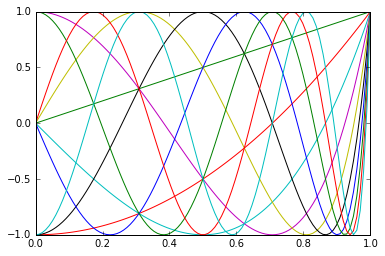

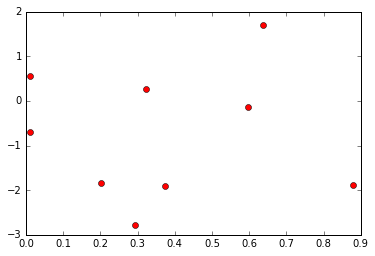

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

def polyval(coefs, x):
    res = coefs[0]*np.ones((1,x.shape[0]))
    for i in xrange(1,len(coefs)):
        res = res + coefs[i]*np.power(x,i)
    return res
        

def chebys (coefs, x):
    pol = {}
    pol[0] = [1][::-1]
    pol[1] = [1, 0][::-1]
    pol[2] = [2, 0, -1][::-1]
    pol[3] = [4, 0, -3, 0][::-1]
    pol[4] = [8, 0, -8, 0, 1][::-1]
    pol[5] = [16, 0, -20, 0, 5, 0][::-1]
    pol[6] = [32, 0, -48, 0, 18, 0, -1][::-1]
    pol[7] = [64, 0, -112, 0, 56, 0, -7, 0][::-1]
    pol[8] = [128, 0, -256, 0, 160, 0, -32, 0, 1][::-1]
    pol[9] = [256, 0, -576, 0, 432, 0, -120, 0, 9, 0][::-1]
    pol[10] = [512, 0, -1280, 0, 1120, 0, -400, 0, 50, 0, -1][::-1]
    pol[11] = [1024, 0, -2816, 0, 2816, 0, -1232, 0, 220, 0, -11, 0][::-1]

    res = np.zeros((1,x.shape[0]))

    for i in xrange(len(coefs)):
        res= res + coefs[i]*polyval(pol[i],x)
    return res

        
x = np.linspace(0,1,100)

%matplotlib inline
import matplotlib.pyplot as plt

for i in xrange(11):
    co = np.zeros((11,))
    co[i]=1.
    plt.plot(x,chebys(co,x).ravel())
    
#Create a polynomial with noise
np.random.seed(42)
coefs = np.random.random(11)

x = np.linspace(0,1,100)

vals=chebys(coefs,x).ravel()
#plt.plot(x,vals)

N=9
idx = np.random.randint(0,100,N)
data = vals[idx]+1.*np.random.normal(size=len(idx))
plt.figure()
plt.plot(x[idx],data,'ro')

x_train = x[idx][:,np.newaxis]
y_train = data[:,np.newaxis]

In [4]:
X = np.c_[np.ones((x_train.shape[0],1)),x_train,x_train**2,x_train**3,x_train**4,x_train**5,x_train**6,x_train**7,x_train**8,x_train**9,x_train**10].T

(-10, 10)

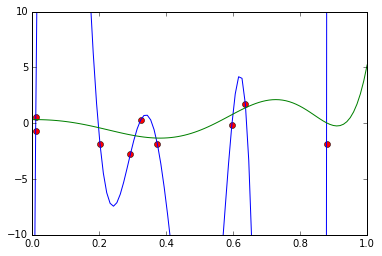

In [5]:
w_analytic = np.dot(np.linalg.pinv(np.dot(X,X.T)),np.dot(X,y_train))
x_draw = np.linspace(0,1,100)

x_extended = np.c_[np.ones((100,1)),x_draw,x_draw**2,x_draw**3,x_draw**4,x_draw**5,x_draw**6,x_draw**7,x_draw**8,x_draw**9,x_draw**10].T

y_hat = np.dot(x_extended.T,w_analytic)

plt.plot(x_train,y_train,'ro')
plt.plot(x_draw,y_hat)
plt.plot(x,vals)
plt.gca().set_ylim([-10,10])

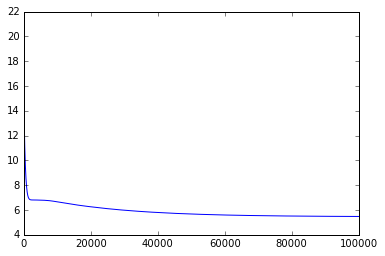

In [6]:
X = np.c_[np.ones((x_train.shape[0],1)),x_train,x_train**2,x_train**3,x_train**4,x_train**5,x_train**6,x_train**7,x_train**8,x_train**9,x_train**10].T

import numpy as np

#initialize weights
w = np.zeros((11,1))
conv = []
wpath = []
wpath.append(w)
n_iters = 100000   # playing with the number for the next exercise. 
Jopt = 9e16
wopt = w
mbatch_size=6
step = 0.01
epsilon = 1e-16
D = np.zeros((11,1))
m = w
g1 = 0.9
g2 = 0.999
for k in xrange(1,n_iters):
    #get a noisy gradient by just taking one data point at random and get the instantaneous gradient
    i = np.random.randint(0,X.shape[1],size=mbatch_size)
    #x_sample = X[:,i]
    #y_sample = y_train[i,:]
    x_sample = X
    y_sample = y_train
    g_tilde = -2*np.dot(x_sample,(y_sample-np.dot(x_sample.T,w)))
    #m = g1*m - g_tilde
    #w = w + step * m
    if k%(n_iters/3.)==0:
        step = step/5.
    m = g1*m - (1-g1)*g_tilde
    D = g2*D + (1-g2)*g_tilde*g_tilde
    w = w  + step * m / np.sqrt(D + epsilon)
    
    
    #Keep the best weight up to that point 
    J=np.sum((np.dot(X.T,w)-y_train)*(np.dot(X.T,w)-y_train))
    if J<Jopt:
        wopt = w
        Jopt = J
    conv.append(J)
    #Project if needed
    ## Add your projection code here
    
plt.plot(conv)
#plt.gca().set_ylim([0.,5.])

(-10, 10)

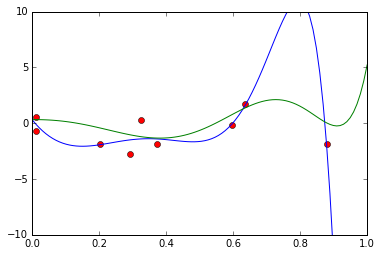

In [7]:
x_draw = np.linspace(0,1,100)

x_extended = np.c_[np.ones((100,1)),x_draw,x_draw**2,x_draw**3,x_draw**4,x_draw**5,x_draw**6,x_draw**7,x_draw**8,x_draw**9,x_draw**10].T

y_hat = np.dot(x_extended.T,wopt)

plt.plot(x_train,y_train,'ro')
plt.plot(x_draw,y_hat)
plt.plot(x,vals)
plt.gca().set_ylim([-10,10])


In [8]:
print w.T,w_analytic.T

[[  2.92468590e-01  -3.75480918e+01   1.83828412e+02  -2.36676476e+02
   -1.53102225e+02   1.38017562e+02   2.80884924e+02   2.46223662e+02
    6.22189490e+01  -2.11037026e+02  -4.24982030e+02]] [[ -4.19160473e+01   4.70445819e+03  -5.82529370e+04   2.73297982e+05
   -5.35435531e+05   2.39510800e+05   4.01327762e+05  -7.40435720e+04
   -4.09839932e+05  -2.26444285e+05   4.03741259e+05]]


# Early stoping 

<div class = "alert alert-success" style = "border-radius:10px">**EXERCISE: ** Change the value of `n_iters` to $100000$, $10000$, $1000$, $100$, and $10$. Create a plot with the in-sample and the out-of-sample values for the former problem. What is the effect of not letting the method converge?
</div>

In [9]:
#your code here

# Xiaoxia: changing directly in the code above. We are actually getting better with less iteration (no letting the method converge).
# it's one way to combate overfitting. 

# Combating overfitting

The reasoning on how to cure overfitting comes from the very well known bound
$$E_{out}\leq E_{in} + \mathcal{O}(\sqrt{\frac{C}{N}})$$

We want to control the out-of-sample error, thus we have a couple of routes to take:

1. Either we simulate the out-of-sample error and check against unseen data. This is working directly with the left hand side of the inequality. We can do this using **cross-validation**.
2. We change the learning objective to take into account and minimize the complexity of the model. We mimick the right hand side of the inequality and add to the objective function a term penalizing complexity. This is called **regularization**.

3. We can use **ensemble techniques**. Implicitly this strategy is similar to the complexity control technique.

# Combating overfitting with norms: A matter of balls

The definition of complexity of a model is ambiguous. Does it mean that it depends on a few elements of a basis? Is it related to the smoothness of the solution? The norm of a vector 

>In linear algebra, functional analysis, and related areas of mathematics, a norm is a function that assigns a strictly positive length or size to each vector in a vector space—save for the zero vector, which is assigned a length of zero. - *Wikipedia*

A very well known norm to use is $\ell_p$ norm, defined as

$$\|\alpha\|_p = \big(\sum_i |\alpha_i|^p\big)^{1/p}$$

Let us have a look at some of them,

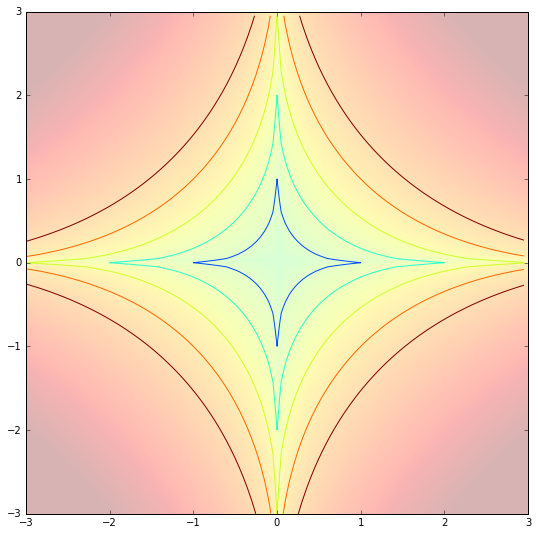

In [10]:
#order = np.Inf
order = 0.5   # playing with this order, and see what happen
delta = 0.05
xx = np.arange(-3.0, 3.0, delta)
yy = np.arange(-3.0, 3.0, delta)
XX, YY = np.meshgrid(xx, yy)
Xf = XX.flatten()
Yf = YY.flatten()
sz=XX.shape
data = np.concatenate([Xf[:,np.newaxis],Yf[:,np.newaxis]],axis=1)
Z = np.linalg.norm(data,ord = order,axis = 1)
Z.shape=sz
plt.imshow(Z, interpolation='bilinear', origin='lower', extent=(-3,3,-3,3),alpha=0.3, vmin=-10, vmax=10)
plt.contour(XX,YY,Z,[0,1,2,3,4,5])
fig = plt.gcf()
fig.set_size_inches(9,9)

<div class = "alert alert-success" style = "border-radius:10px">**EXERCISE: ** Change the value of `order` to $0.5$, $1$, and `np.Inf`. Consider that we add a norm of the desired order to the linear regression problem. What is the expected effect of each of the norms?</div>

In [11]:
# PARETO'S OPTIMA SUERFACE
# If no convex, we may miss some solutions

Let us check the effect of adding a norm to the problem. Remember that by adding the norm we are trying to simulate the right hand side of equation 

$$E_{out} \leq E_{in} + \mathcal{O}(\sqrt{\frac{C}{N}})$$

where the norm is a potential measure of the complexity of the model.

In that case, the optimization problem becomes

$$
\begin{align}
\text{minimize } & \quad (f_0(x), \|x\|_p)\\
\text{subject to } & \quad f_i(x)\leq 0, \quad  \; i = 1,\dots, m,
\end{align}
$$

where $x$ is the variable we are optimizing (not to be confused with the data when applying to the machine learning case). Adding a new term to optimize with repect to, converts the problem into a multiple optimization problem. This usually means that there is not a unique solution since usually the different functions to be optimized compete. The surface of all solutions is called *Pareto's optimal surface*. One way to travel along the Pareto's surface is to use a method called scalarization. This consists of making a weighted combination of both functions

$$
\begin{align}
\text{minimize } & \quad f_0(x) + \lambda \|x\|_p\\
\text{subject to } & \quad f_i(x)\leq 0, \quad  \; i = 1,\dots, m,
\end{align}
$$

Let us solve the problem of least squares with different norms and see what happens.

We will use CVXPY, a disciplined convex optimization module that allows to solve convex optimization problems. Find in the following lines an example.

In [25]:
from cvxpy import *
import numpy

d = X.shape[0]
N = X.shape[1]

# Construct the problem.
w = Variable(d)
error = sum_squares(X.T*w - y_train)
obj = Minimize(error)
prob = Problem(obj)
prob.solve()

2.956134238846497e-10

### Xiaoxia: Modified version: play with lamda

- Lambda: If lamba is 0 (free fit), then there are more oscilation. The bigger is the lambda, the smaller is the oscilation.

- Norm: when we set norm 1, there are many "Near zero values", this means that many feature are meaningless. 

Near zero values: 10
[[ -6.88752982e-01]
 [ -1.56263734e-09]
 [ -4.53264241e-10]
 [ -1.41158762e-09]
 [ -3.17924143e-09]
 [ -4.80967834e-09]
 [ -6.28826962e-09]
 [ -6.14268255e-09]
 [ -4.92397053e-09]
 [ -4.31923928e-09]
 [ -3.54671939e-09]]


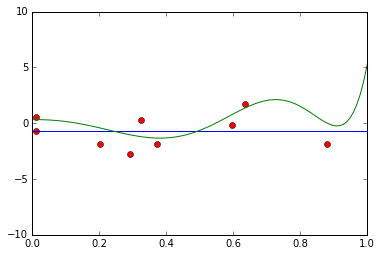

In [49]:
# Modified version: play with lamda and norm

from cvxpy import *
import numpy

lambd = 1  # play with the value
d = X.shape[0]
N = X.shape[1]

# Construct the problem.
w = Variable(d)
error = sum_squares(X.T*w - y_train)
obj = Minimize(error + lambd*norm(w,1))  # play with the norm
prob = Problem(obj)
prob.solve()

%matplotlib inline

x_draw = np.linspace(0,1,100)
x_extended = np.c_[np.ones((100,1)),x_draw,x_draw**2,x_draw**3,x_draw**4,x_draw**5,x_draw**6,x_draw**7,x_draw**8,x_draw**9,x_draw**10].T
y_hat = np.dot(x_extended.T,w.value)

plt.plot(x_train,y_train,'ro')
plt.plot(x_draw,y_hat)
plt.plot(x,vals)
plt.gca().set_ylim([-10,10])

# check the coeficient
print 'Near zero values: ' + str(len(np.where(np.abs(w.value)<1e-6)[0]))
print w.value

In [50]:
prob.status

'optimal'

In [51]:
print 'Near zero values: ' + str(len(np.where(np.abs(w.value)<1e-6)[0]))

print w.value

Near zero values: 10
[[ -6.88752982e-01]
 [ -1.56263734e-09]
 [ -4.53264241e-10]
 [ -1.41158762e-09]
 [ -3.17924143e-09]
 [ -4.80967834e-09]
 [ -6.28826962e-09]
 [ -6.14268255e-09]
 [ -4.92397053e-09]
 [ -4.31923928e-09]
 [ -3.54671939e-09]]


(-10, 10)

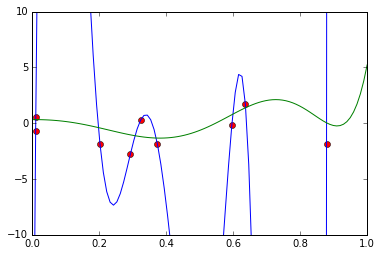

In [15]:
%matplotlib inline

x_draw = np.linspace(0,1,100)

x_extended = np.c_[np.ones((100,1)),x_draw,x_draw**2,x_draw**3,x_draw**4,x_draw**5,x_draw**6,x_draw**7,x_draw**8,x_draw**9,x_draw**10].T

y_hat = np.dot(x_extended.T,w.value)

plt.plot(x_train,y_train,'ro')
plt.plot(x_draw,y_hat)
plt.plot(x,vals)
plt.gca().set_ylim([-10,10])

<div class = "alert alert-success" style = "border-radius:10px">**EXERCISE: ** Modify the code to accomodate $\ell_p$ norm regularization. Observe the values of the weights in the different configuration of the norms. Describe them.</div>

In [16]:
#your code

(-10, 10)

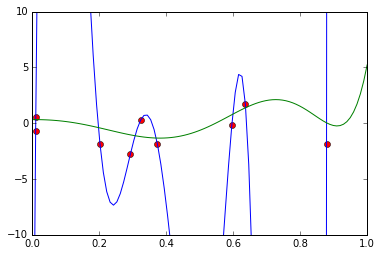

In [17]:
%matplotlib inline

x_draw = np.linspace(0,1,100)

x_extended = np.c_[np.ones((100,1)),x_draw,x_draw**2,x_draw**3,x_draw**4,x_draw**5,x_draw**6,x_draw**7,x_draw**8,x_draw**9,x_draw**10].T

y_hat = np.dot(x_extended.T,w.value)

plt.plot(x_train,y_train,'ro')
plt.plot(x_draw,y_hat)
plt.plot(x,vals)
plt.gca().set_ylim([-10,10])

# Using stochastic subgradient methods

Let us modify our stochastic subgradient method to achieve the same performance.

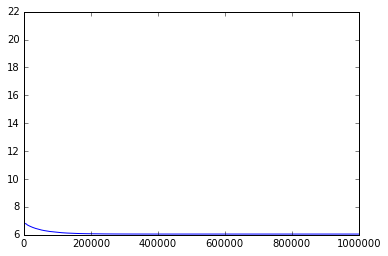

In [52]:
X = np.c_[np.ones((x_train.shape[0],1)),x_train,x_train**2,x_train**3,x_train**4,x_train**5,x_train**6,x_train**7,x_train**8,x_train**9,x_train**10].T

import numpy as np

#initialize weights
w = np.zeros((11,1))
conv = []
wpath = []
wpath.append(w)
n_iters = 1000000
Jopt = 9e16
wopt = w
mbatch_size=6
step = 0.01
epsilon = 1e-16
D = w
m = w
g1 = 0.9
g2 = 0.999
gamma = 0.001
for k in xrange(1,n_iters):
    #get a noisy gradient by just taking one data point at random and get the instantaneous gradient
    i = np.random.randint(0,X.shape[1],size=mbatch_size)
    #x_sample = X[:,i]
    #y_sample = y_train[i,:]
    x_sample = X
    y_sample = y_train
    g_tilde = -2*np.dot(x_sample,(y_sample-np.dot(x_sample.T,w))) + gamma*np.sign(w)
    #m = g1*m - g_tilde
    #w = w + step * m
    if k%(n_iters/3.)==0:
        step = step/5.
    m = g1*m - (1-g1)*g_tilde
    D = g2*D + (1-g2)*g_tilde*g_tilde
    w = w  + step * m / np.sqrt(D + epsilon)
    
    
    #Keep the best weight up to that point 
    J=np.sum((np.dot(X.T,w)-y_train)*(np.dot(X.T,w)-y_train))
    if J<Jopt:
        wopt = w
        Jopt = J
    conv.append(J)
    #Project if needed
    ## Add your projection code here
    
plt.plot(conv)
#plt.gca().set_ylim([0.,5.])

In [19]:
wopt

array([[  1.10162620e-01],
       [ -2.14337122e+01],
       [  8.65526639e+01],
       [ -1.18229722e+02],
       [  3.41255733e-04],
       [  5.66969754e-03],
       [  1.88341333e+02],
       [  4.57063903e-03],
       [  1.50080527e-03],
       [ -5.41658595e-03],
       [ -2.05694626e+02]])

(-10, 10)

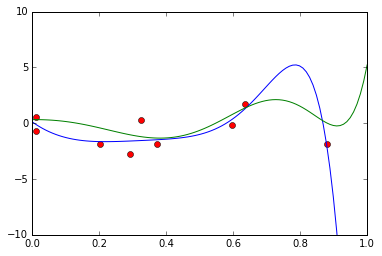

In [20]:
%matplotlib inline

x_draw = np.linspace(0,1,100)

x_extended = np.c_[np.ones((100,1)),x_draw,x_draw**2,x_draw**3,x_draw**4,x_draw**5,x_draw**6,x_draw**7,x_draw**8,x_draw**9,x_draw**10].T

y_hat = np.dot(x_extended.T,wopt)

plt.plot(x_train,y_train,'ro')
plt.plot(x_draw,y_hat,'b')
plt.plot(x,vals,'g')
plt.gca().set_ylim([-10,10])

# Data augmentation and the dropout technique

The goal of regularization is to avoid overfitting. We have seen that one way of avoiding overfitting is not to let the method overfit. Overfitting occurs when the relationship between the complexity of the method and the number of available samples is large. This is, the model is too much complex for the amount of data. One way of delaying overfitting is to artificially create new data. This is called **data augmentation**. 



<div class = "alert alert-success" style = "border-radius:10px"> **EXERCISE: ** Discuss with your partner posible ways for augmenting data.</div>

We may estimate the probability density function and then sample from that. Or use interpolation methods. Another technique is to add noise to the current data while perserving the label from the original data. This is the basic idea behind the **dropout** technique. In this technique one cancels the value of the attributes at random when training. This is esentially the same as adding "salt and pepper" noise.

Xiaoxia: si a una imagen de perro, le quita un pixel, tu metodo deberia detectar que la nueva imagen tambien es un perro. es una  manera de augmentar el numero de sample.

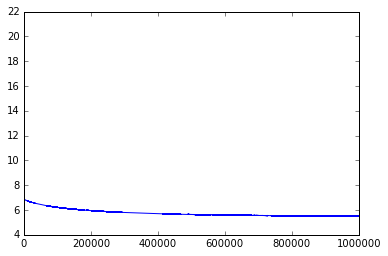

In [61]:
X = np.c_[np.ones((x_train.shape[0],1)),x_train,x_train**2,x_train**3,x_train**4,x_train**5,x_train**6,x_train**7,x_train**8,x_train**9,x_train**10].T

import numpy as np

#initialize weights
w = np.zeros((11,1))
conv = []
wpath = []
wpath.append(w)
n_iters = 1000000
Jopt = 9e16
wopt = w
mbatch_size=6
step = 0.01
epsilon = 1e-16
D = w
m = w
g1 = 0.9
g2 = 0.999
gamma = 0.00
prc = 0.001
for k in xrange(1,n_iters):
    #get a noisy gradient by just taking one data point at random and get the instantaneous gradient
    i = np.random.randint(0,X.shape[1],size=mbatch_size)
    #x_sample = X[:,i]
    #y_sample = y_train[i,:]
    x_sample = X
    y_sample = y_train
    
    ## DROPOUT
    #n = np.random.rand(X.shape[0],X.shape[1])<prc
    #x_sample[n] = 0.
    
    ## NOISY AUGMENTATION
    #x_sample[n] =  x_sample[n] + step/100. *np.random.normal()     #delete"[n]". take all sample instead of a percentage of samples
    x_sample =  x_sample + step/100. *np.random.normal()   
    
    g_tilde = -2*np.dot(x_sample,(y_sample-np.dot(x_sample.T,w))) + gamma*np.sign(w)  # could change "np.sign(w)" to w
    #m = g1*m - g_tilde
    #w = w + step * m
    if k%(n_iters/3.)==0:
        step = step/5.
    m = g1*m - (1-g1)*g_tilde
    D = g2*D + (1-g2)*g_tilde*g_tilde
    w = w  + step * m / np.sqrt(D + epsilon)
    
    
    #Keep the best weight up to that point 
    J=np.sum((np.dot(X.T,w)-y_train)*(np.dot(X.T,w)-y_train))
    if J<Jopt:
        wopt = w
        Jopt = J
    conv.append(J)
    #Project if needed
    ## Add your projection code here
    
plt.plot(conv)
#plt.gca().set_ylim([0.,5.])

(-10, 10)

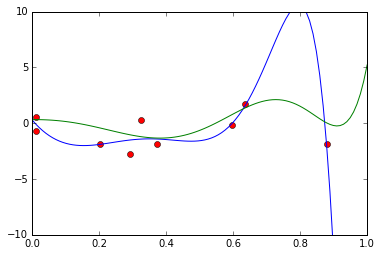

In [60]:
%matplotlib inline

x_draw = np.linspace(0,1,100)

x_extended = np.c_[np.ones((100,1)),x_draw,x_draw**2,x_draw**3,x_draw**4,x_draw**5,x_draw**6,x_draw**7,x_draw**8,x_draw**9,x_draw**10].T

y_hat = np.dot(x_extended.T,wopt)

plt.plot(x_train,y_train,'ro')
plt.plot(x_draw,y_hat,'b')
plt.plot(x,vals,'g')
plt.gca().set_ylim([-10,10])

In [57]:
# Xiaoxia: in our example, dropoff means change one point to (0,0). This does not make any sense. adding noise, that do make sense.